# Sentiment Analysis on TripAdvisor Hotel Reviews

- natural language processing (NLP) technique used to determine whether data is positive, negative, or neutral
- gauge public opinion, conduct market research, monitor brand and product reputation, and understand customer experiences


Libraries used:
- Pandas : powerful Python library for data manipulation and analysis, providing data structures and functions to efficiently work with tabular data
- NLTK : library for Natural Language Processing
- Scikit-learn : provides functions for training, predicting, and evaluating models.

<br>
<br>

In [18]:
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import nltk
import re
import string

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Ryzen
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading data


In [32]:
df = pd.read_csv('./Dataset/tripadvisor_hotel_reviews.csv')
df.head()
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

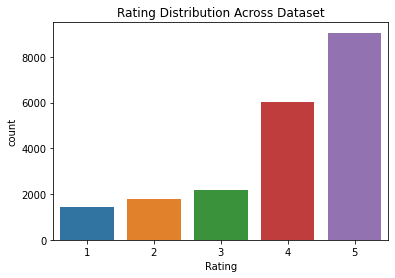

In [20]:
sns.countplot(data=df, x='Rating').set_title('Rating Distribution Across Dataset')
df.Rating.value_counts()

### Preprocessing Data


Text(0.5, 1.0, 'Sentiment Distribution')

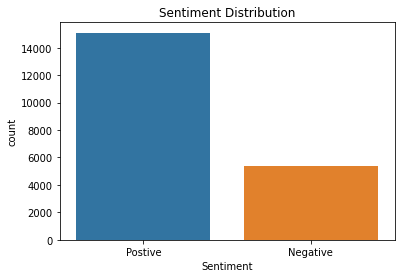

In [21]:
positive = [4, 5]
negative = [1, 2, 3]


def map_sentiment(rating):
    if rating in positive:
        return 'Postive'
    else:
        return 'Negative'


df['Sentiment'] = df['Rating'].apply(map_sentiment)
sns.countplot(data=df, x='Sentiment').set_title('Sentiment Distribution')


In [22]:
review = df['Review'][1]
print('Original:')
print(review)
print()

sentence = []
for word in review.split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run b

In [23]:
def clean_text(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(.)\1\1+', r"\1\1", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w) > 2]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    text = ' '.join(tokens)
    return text


# Apply new function
df['Review'] = df['Review'].apply(clean_text)


In [24]:
df.to_csv('./Dataset/cleaned_df.csv', index=False)

### TF-IDF vectorization:
- algorithm that uses the frequency of words to determine how relevant those words are to a given document

  <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*qQgnyPLDIkUmeZKN2_ZWbQ.png" width="500">


In [25]:
# Prepare data for modeling
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(df['Review'])
y = df['Sentiment']

pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

### Split training and testing data
Model validation procedure that reveals how model performs on new data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=24)

### Cross Validation 

  <img src="https://www.section.io/engineering-education/how-to-implement-k-fold-cross-validation/5-fold-cv.jpeg" width=500>

  <img src="https://i0.wp.com/why-change.com/wp-content/uploads/2021/11/Decision-Tree-elements-2.png?resize=715%2C450&ssl=1" width=500>

In [27]:
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_jobs=-1),
    # SVC(),
    # LogisticRegression(),
    # KNeighborsClassifier(),
    # BernoulliNB(),
]

accuracy = []

for model in models:
    print(model, 'start')
    cross_val = cross_val_score(model, X_train, y_train, scoring='accuracy', n_jobs=-1).mean()
    accuracy.append(cross_val)
    print(model, 'complete')


DecisionTreeClassifier() start
DecisionTreeClassifier() complete
RandomForestClassifier(n_jobs=-1) start
RandomForestClassifier(n_jobs=-1) complete


In [28]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.774218
1,RandomForestClassifier,0.858041


In [29]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [31]:
def ml_predict(text):
    cleaned_text = clean_text(text)
    tfid_matrix = tfidf.transform([cleaned_text])
    pred_proba = model.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = model.classes_[idx]

    return pred, pred_proba[0][idx]


reviews = [
    'I received the best service from Jenna Joy at the Crockfords front desk. She was the most genuine and helpful person I met on my entire trip. I do appreciated her helpfulness and kindness. This resort is gorgeous but the service is what made my stay outstanding.',
    'This is a beautiful hotel- however they DO NOT ANSWER THE PHONE for their guests. 2nd night in a row, after a long flight and long day of meetings called to order room service, only for NO ONE to answer the phone!',
	'They charged us for room damage that my wife and I never did and they could not show us any proof that we did it, they just charged our credit card extra after we left back to Canada. Scammed or the maid did it and blamed us so she wouldn’t get in trouble'
]

for review in reviews:
    print(ml_predict(review))


('Postive', 0.85)
('Postive', 0.51)
('Negative', 0.77)
